In [2]:
%pip install import tensorflow as tf
%pip install timm

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement import (from versions: none)
ERROR: No matching distribution found for import


Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tensorflow
%pip install tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [5]:
import requests

url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
response = requests.get(url, stream=True)

if response.status_code == 200:
    with open('images.tar', 'wb') as file:
        file.write(response.content)
else:
    print(f'Failed to download file, status code: {response.status_code}')


In [6]:
import tarfile

with tarfile.open('images.tar') as tar:
    tar.extractall()

In [7]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset_path = './Images'
dataset = datasets.ImageFolder(dataset_path, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Define the model path
model_path = "D:/resnet50_trained.pth"
#model_path = '/content/gdrive/My Drive/resnet50_trained.onnx'
# Load the trained model
model = torch.load(model_path)
model.eval()  # Set the model to evaluation mode

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict(input_image: Image):
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)

    # Assuming 'dataset' is your ImageFolder dataset
    class_to_idx = dataset.class_to_idx
    idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

    return idx_to_class[predicted_idx.item()]

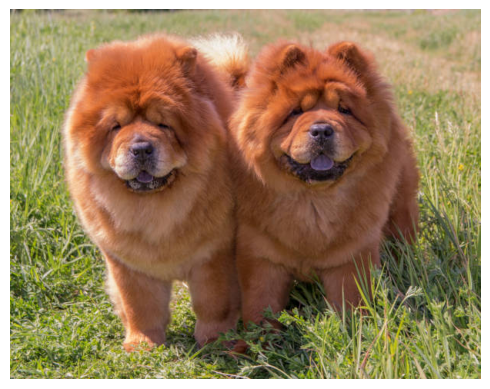

The predicted class of the test image is: chow


In [9]:
# Test Case 1
from PIL import Image
import matplotlib.pyplot as plt

test_image_path = "D:/Img_1.jpg"
test_image = Image.open(test_image_path)

# Show the image
plt.imshow(test_image)
plt.axis('off')
plt.show()

# Run prediction function on the test image
predicted_class = predict(test_image)
class_idx, class_name = predicted_class.split("-")
class_name = class_name.replace("_", " ")
print(f"The predicted class of the test image is: {class_name}")


In [10]:
%pip install flask-ngrok


Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install --upgrade flask-ngrok


In [15]:
import os
import json
from flask import Flask, request, jsonify, render_template
from PIL import Image
import torch
from torchvision import transforms, datasets

# Define the Flask app
app = Flask(__name__)

# Define the model path
model_path = os.path.join(".", "resnet50_trained.pth")

# Load the trained model
model = torch.load(model_path, map_location='cpu')
model.eval()  # Set the model to evaluation mode

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset_path = os.path.join(".", "Images")
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Map classes to indices
class_to_idx = dataset.class_to_idx
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

@app.route('/', methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        file = request.files.get('image')
        if file is None:
            return jsonify({'error': 'no file'}), 400

        image = Image.open(file.stream)
        image = transform(image)
        image = image.unsqueeze(0)

        with torch.no_grad():
            output = model(image)

        _, predicted_idx = torch.max(output, 1)
        predicted_class = idx_to_class[predicted_idx.item()]
        class_idx, class_name = predicted_class.split("-")
        class_name = class_name.replace("_", " ")

        return jsonify({'predicted_class': class_name})

    else:
        return render_template('index.html')

# Run the Flask application
if __name__ == '__main__':
    app.run(port=8080)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8080
Press CTRL+C to quit
